In [5]:
import torch 
import numpy as np  
import torch.nn.functional as F 
from torch.utils.data import DataLoader, Dataset  

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt
from utils import *

In [6]:
def train(model, total_steps=500, num_print=5):
    print("===================================================")
    print(f"{model.__class__}, {model.activation}")

    optim = torch.optim.Adam(lr=1e-4, params=model.parameters())
    model_input, ground_truth = next(iter(dataloader))
    if torch.cuda.is_available():
        model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

    for step in range(total_steps):
        model_output, coords = model(model_input) 
        loss = ((model_output - ground_truth)**2).mean()
        steps_till_summary = total_steps //num_print
        if not step % steps_till_summary:
            print("Step %d, Total loss %0.6f" % (step, loss))

            img_grad = gradient(model_output, coords)
            img_laplacian = laplace(model_output, coords)
            fig, axes = plt.subplots(1,3, figsize=(4,2))
            axes[0].imshow(model_output.cpu().view(256,256).detach().numpy())
            axes[1].imshow(img_grad.norm(dim=-1).cpu().view(256,256).detach().numpy())
            axes[2].imshow(img_laplacian.cpu().view(256,256).detach().numpy())
            plt.tight_layout()
            plt.show()

        optim.zero_grad()
        loss.backward()
        optim.step()

In [7]:
from siren import * 
from fcn import * 
cameraman = ImageFitting(256)
dataloader = DataLoader(cameraman, batch_size=1, pin_memory=True, num_workers=0)

img_siren = Siren(in_features=2, out_features=1, hidden_features=256, 
                  hidden_layers=1, outermost_linear=True)
img_relu = FCN(in_features=2, out_features=1, hidden_features=256, 
                  hidden_layers=3, outermost_linear=True, activation=F.relu)
img_tanh = FCN(in_features=2, out_features=1, hidden_features=256, 
                  hidden_layers=3, outermost_linear=True, activation=torch.tanh)
img_sigmoid = FCN(in_features=2, out_features=1, hidden_features=256, 
                  hidden_layers=3, outermost_linear=True, activation=torch.sigmoid)
img_leakyrelu = FCN(in_features=2, out_features=1, hidden_features=256, 
                  hidden_layers=3, outermost_linear=True, activation=F.leaky_relu)
img_logsigmoid = FCN(in_features=2, out_features=1, hidden_features=256, 
                  hidden_layers=3, outermost_linear=True, activation=F.logsigmoid)



if torch.cuda.is_available():
    img_siren = img_siren.cuda()
    img_relu = img_relu.cuda()
    img_tanh = img_tanh.cuda()
    img_sigmoid = img_sigmoid.cuda()
    img_leakyrelu = img_leakyrelu.cuda()
    img_logsigmoid= img_logsigmoid.cuda()

<class 'siren.Siren'>, siren
Step 0, Total loss 0.250798


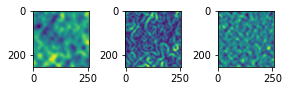

Step 3, Total loss 0.201086


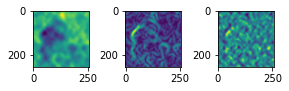

Step 6, Total loss 0.163037


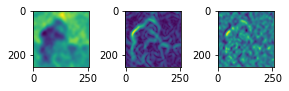

Step 9, Total loss 0.132983


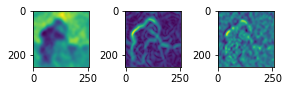

<class 'fcn.FCN'>, <function relu at 0x7f6e9f6f67b8>
Step 0, Total loss 0.229862


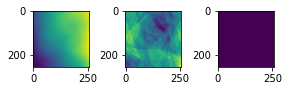

Step 3, Total loss 0.229409


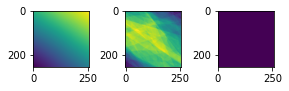

Step 6, Total loss 0.229029


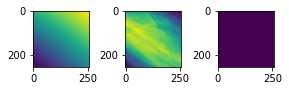

Step 9, Total loss 0.228646


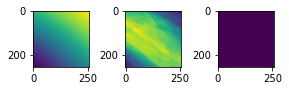

<class 'fcn.FCN'>, <built-in method sigmoid of type object at 0x7f6f6d6e74a0>
Step 0, Total loss 0.778559


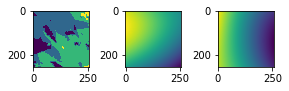

Step 3, Total loss 0.620187


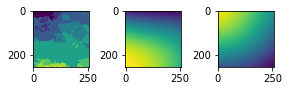

Step 6, Total loss 0.488704


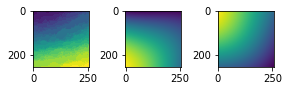

Step 9, Total loss 0.384712


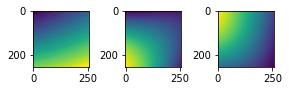

<class 'fcn.FCN'>, <built-in method tanh of type object at 0x7f6f6d6e74a0>
Step 0, Total loss 0.249792


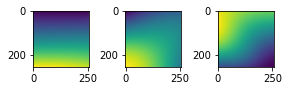

Step 3, Total loss 0.243175


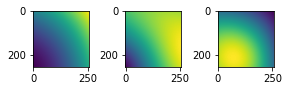

Step 6, Total loss 0.236886


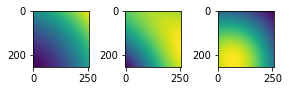

Step 9, Total loss 0.230584


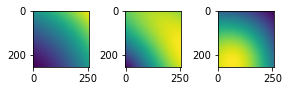

<class 'fcn.FCN'>, <function leaky_relu at 0x7f6e9f6f6b70>
Step 0, Total loss 0.244599


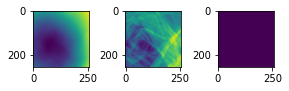

Step 3, Total loss 0.242663


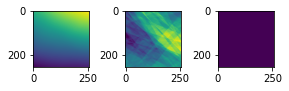

Step 6, Total loss 0.240737


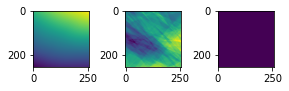

Step 9, Total loss 0.238726


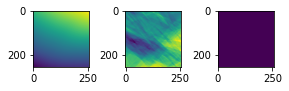

<class 'fcn.FCN'>, <built-in function log_sigmoid>
Step 0, Total loss 0.442861


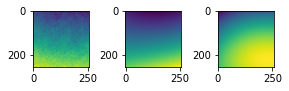

Step 666, Total loss 0.179026


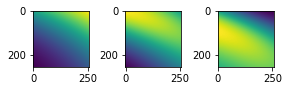

Step 1332, Total loss 0.086120


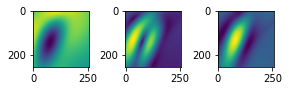

Step 1998, Total loss 0.083120


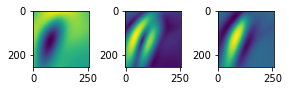

In [8]:
plot_num_images = 3
train(img_siren, 10, plot_num_images)
train(img_relu, 10, plot_num_images)
train(img_sigmoid, 10, plot_num_images)
train(img_tanh, 10, plot_num_images)
train(img_leakyrelu, 10, plot_num_images)
train(img_logsigmoid, 2000, plot_num_images)